# Causal Identification Module Research and Testing

In [5]:
#Causal Graph Viz for slide
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Markdown
import pandas as pd
import numpy as np
import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
from dowhy import CausalModel
style.use("fivethirtyeight")

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
#Import discovery module
import sys
import os

module_path = os.path.abspath(os.path.join('..', 'E2E_Self_Serve_CI_Tool', 'diice'))
if module_path not in sys.path:
    sys.path.append(module_path)

from discovery import *

In [7]:
#load data and trained dag

# 1991 Survey of Income and Program Participation (401k) - very small weight for treatment (net_tfa) from discovery
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.csv"
data = pd.read_csv(file)

#load learned DAG
W_avg = np.loadtxt(r'C:\Users\tomle\OneDrive\Documents\Projects\Causal-Inference\E2E_Self_Serve_CI_Tool\learned_dag_401k_dagma_NL.txt', dtype=np.float64)

#colnames
t = 'e401'
select_data = data[data.columns[:-12]]
# select_data = data.loc[:, data.nunique() > 2]
select_data[t] = data[t]
col_names = select_data.columns
data.head()

,ira,a401,hval,hmort,hequity,nifa,net_nifa,tfa,net_tfa,tfa_he,tw,age,inc,fsize,educ,db,marr,male,twoearn,dum91,e401,p401,pira,nohs,hs,smcol,col,icat,ecat,zhat,net_n401,hown,i1,i2,i3,i4,i5,i6,i7,a1,a2,a3,a4,a5
0,0,0,69000,60150,8850,100,-3300,100,-3300,5550,53550,31,28146,5,12,0,1,0,0,1,0,0,0,0,1,0,0,3,2,0.273178,-3300,1,0,0,1,0,0,0,0,0,1,0,0,0
1,0,0,78000,20000,58000,61010,61010,61010,61010,119010,124635,52,32634,5,16,0,0,0,0,1,0,0,0,0,0,0,1,4,4,0.386641,61010,1,0,0,0,1,0,0,0,0,0,0,1,0
2,1800,0,200000,15900,184100,7549,7049,9349,8849,192949,192949,50,52206,3,11,0,1,1,1,1,0,0,1,1,0,0,0,6,1,0.533650,8849,1,0,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,2487,-6013,2487,-6013,-6013,-513,28,45252,4,15,0,1,0,1,1,0,0,0,0,0,1,0,5,3,0.324319,-6013,0,0,0,0,0,1,0,0,1,0,0,0,0
4,0,0,300000,90000,210000,10625,-2375,10625,-2375,207625,212087,42,33126,3,12,1,0,0,0,1,0,0,0,0,1,0,0,4,2,0.602807,-2375,1,0,0,0,1,0,0,0,0,0,1,0,0


Is pruned graph a DAG (i.e. acyclic)? True


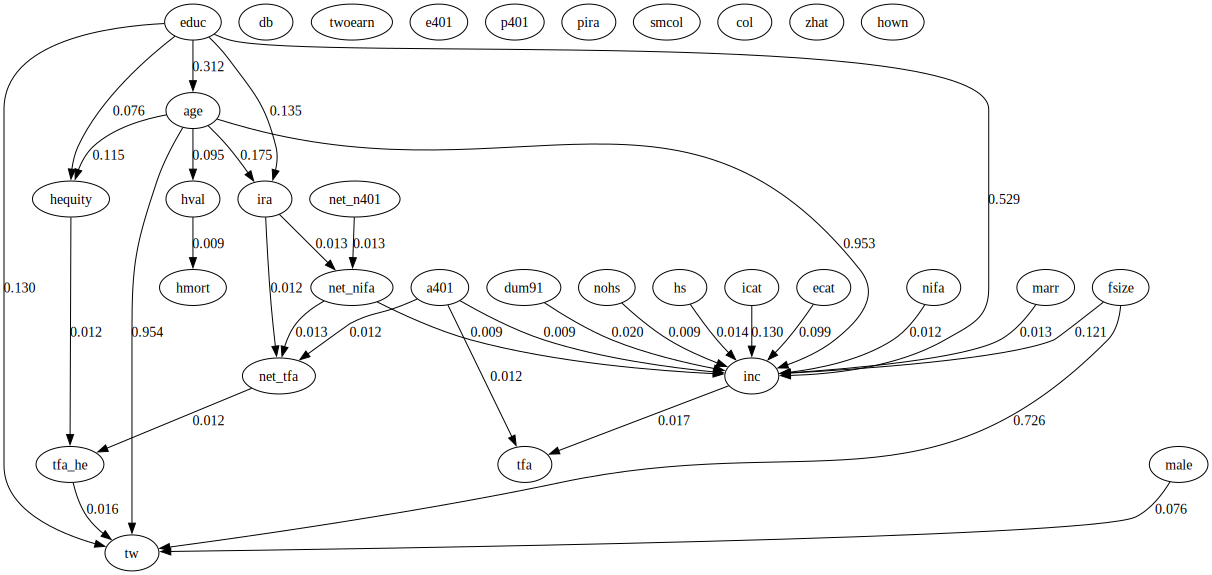

In [8]:
#display average of both DAGs
print('Is pruned graph a DAG (i.e. acyclic)?', utils.is_dag(W_avg))
dot = manual_display_dag(W_avg, col_names)
dot

In [9]:
model = CausalModel(
    data=select_data,
    treatment="educ",
    outcome="net_tfa",
    proceed_when_unidentifiable=True,
    graph=dot.source  # Pass the graph in DOT format

)

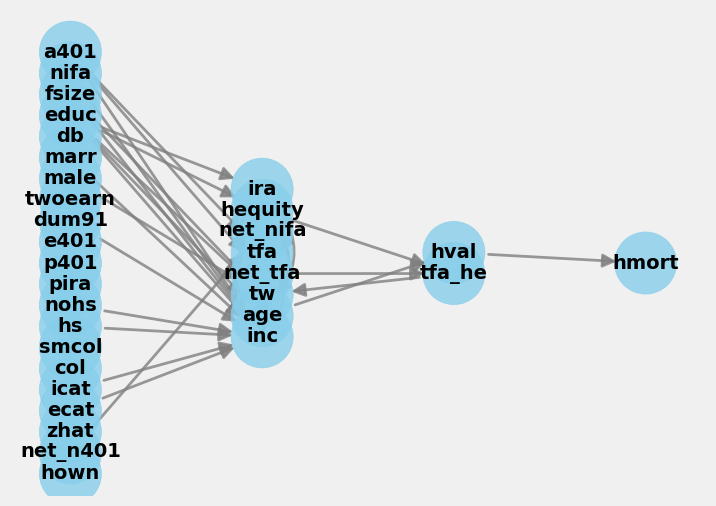

In [10]:
model.view_model()

In [11]:
identified_estimand = model.identify_effect()

In [12]:
print(identified_estimand.backdoor_variables)

{'backdoor1': [], 'backdoor2': ['net_n401', 'a401'], 'backdoor3': ['net_n401'], 'backdoor4': ['a401'], 'backdoor': []}


In [13]:
class CausalIdentifcation():

    """
    Main class for causal identification. Instances of this class will traverse the input DAG and identify valid adjustment sets (set of confounders to control for) that will create conditional independence between T and Y. 

    Parameters
    ----------
    data : pandas.DataFrame
        The input data as a pandas dataframe containing X, T, and Y.
    treatment : str
        The name of the treatment variable.
    outcome : str
        The name of the outcome variable.
    dag : str
        The learned DAG in DOT format.
      """


    def __init__(self, data, treatment: str, outcome: str, dag=None, model=None, identified_estimand=None):
        
        self.data = data
        self.treatment = treatment
        self.outcome = outcome
        self.dag = dag
        self.model, self.identified_estimand = self._identify_effect()

    def _identify_effect(self):
        """
        Builds the causal model and attempts to identify valid adjustment sets through graph traversal using do-calculus from Pearl's (2012) framework of causal inference. Returns the identified estimand and stores it as an instance variable.
        """

        model = CausalModel(
            data=self.data,
            treatment=self.treatment,
            outcome=self.outcome,
            proceed_when_unidentifiable=True,
            graph=self.dag.source  # Pass the graph in DOT format
        )
        identified_estimand = model.identify_effect()
        return model, identified_estimand
    
    def view_model(self):
        """
        Displays the causal model.
        """

        self.model.view_model()

    def get_adj_set(self, criterion='backdoor'):
        """
        Returns the valid adjustment sets.

        Parameters
        ----------
        criterion : str, optional
            The criterion to use for identifying valid adjustment sets. Options are 'backdoor', 'instrumental' and 'frontdoor'. Default is 'backdoor'.
        """
        
        adj_set = getattr(self.identified_estimand, f"{criterion}_variables")
        return adj_set

In [14]:
dowhy_401k_identification = CausalIdentifcation(data=select_data, treatment='educ', outcome='net_tfa', dag=dot)

In [15]:
print(dowhy_401k_identification.get_adj_set(criterion='backdoor'))

{'backdoor1': [], 'backdoor2': ['net_n401', 'a401'], 'backdoor3': ['net_n401'], 'backdoor4': ['a401'], 'backdoor': []}


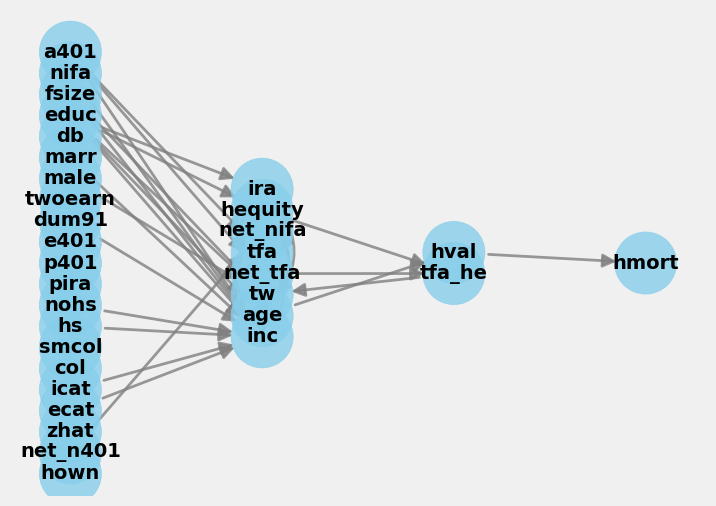

In [16]:
dowhy_401k_identification.view_model()